In [1]:
import math
import re
import random
import requests
from PIL import Image
from io import BytesIO
from pyproj import Transformer
import xml.etree.ElementTree as ET
from ultralytics import YOLO
import matplotlib.pyplot as plt
import supervision as sv
import cv2
import os

### Extracting Image from bhuvan ngmaps

In [2]:
def find_satellite_layers(base_url):
    """
    Sends a GetCapabilities request to find available high-resolution satellite layers.
    """
    print("\nAttempting to dynamically find available satellite layers...")
    params = {'service': 'WMS', 'version': '1.1.1', 'request': 'GetCapabilities'}
    headers = {'User-Agent': 'Mozilla/5.0'}
    try:
        response = requests.get(base_url, params=params, headers=headers)
        response.raise_for_status()
        root = ET.fromstring(response.content)
        all_layers = [name.text for name in root.findall('.//Layer/Name')]
        satellite_layers = [name for name in all_layers if name and ('hrs' in name or 'sat' in name)]
        if satellite_layers:
            print(f"✅ Found potential satellite layers.")
            return satellite_layers
        else:
            print("❌ No satellite layers found in server capabilities.")
            return None
    except requests.exceptions.RequestException as e:
        print(f"❌ Could not get server capabilities: {e}")
        return None

In [3]:
def get_tile_info(lon, lat, zoom):
    """
    Calculates the exact tile index (x, y) and bounding box for a given lat/lon and zoom level.
    """
    lat_rad = math.radians(lat)
    n = 2.0 ** zoom
    # convert longitude to x axis tile coordinates(will be in integer so when converted back to web mercator, will give exact coordinates)
    tile_x = int((lon + 180.0) / 360.0 * n)
    # convert latitude to y axis tile coordinates
    tile_y = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)

    # convert tile_x back to longitude
    def tile_to_lon(x, z):
        return x / (2.0 ** z) * 360.0 - 180.0
        
    # convert tile_y back to latitude
    def tile_to_lat(y, z):
        n = math.pi - 2.0 * math.pi * y / (2.0 ** z)
        return math.degrees(math.atan(0.5 * (math.exp(n) - math.exp(-n))))

    # get north_west(top_left) and south_east(bottom_right) coordinates for bbox of tile
    lon_deg_nw = tile_to_lon(tile_x, zoom)
    lat_deg_nw = tile_to_lat(tile_y, zoom)
    lon_deg_se = tile_to_lon(tile_x + 1, zoom)
    lat_deg_se = tile_to_lat(tile_y + 1, zoom)

    # change crs from 4326(in degree) to 3857(web mercator, in metres)
    transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)
    min_x, min_y = transformer.transform(lon_deg_nw, lat_deg_se)
    max_x, max_y = transformer.transform(lon_deg_se, lat_deg_nw)
    
    return {'x': tile_x, 'y': tile_y, 'bbox': (min_x, min_y, max_x, max_y)}

In [4]:
def generate_custom_stitched_map(target_width=1904, target_height=937):
    """
    Generates a stitched and cropped map image from a Bhuvan URL.
    """
    while True:
        url =input(f"Enter url: ")
        match = re.search(r'#([\d.-]+)/([\d.-]+)/([\d.-]+)', url)
        if not match:
            print("❌ Error: URL format is incorrect. Could not find lat/lon.")
        else:
            break

        
    zoom = 16
    lat = float(match.group(2))
    lon = float(match.group(3))
    print(f"Parsed URL -> Lat: {lat}, Lon: {lon}")

    base_url = "https://bhuvan-ras1.nrsc.gov.in/SatServices/service"

    available_sat_layers = find_satellite_layers(base_url)
    if not available_sat_layers:
        print("Halting execution as no suitable layer could be found.")
        return
        
    print("\nPlease choose a layer to use:")
    for i, layer in enumerate(available_sat_layers):
        print(f"  {i + 1}: {layer}")

    dynamic_layer_name = ""
    while True:
        try:
            choice_str = input(f"Enter your choice (1-{len(available_sat_layers)}): ")
            choice_index = int(choice_str) - 1
            if 0 <= choice_index < len(available_sat_layers):
                dynamic_layer_name = available_sat_layers[choice_index]
                break
            else:
                print("❌ Invalid number. Please try again.")
        except ValueError:
            print("❌ That's not a valid number. Please try again.")
    
    print(f"--> Using selected layer: '{dynamic_layer_name}' for tile requests.\n")

    tile_pixel_size = 256
    grid_width = math.ceil(target_width / tile_pixel_size)
    # for 256x256, there will be 8x4 tile for 1904*937 (default resolution seen on bhuvan) grid which after cropping gets reduced, so that's why 8x6 
    grid_height = math.ceil(target_height / tile_pixel_size)+2
    stitched_width = grid_width * tile_pixel_size
    stitched_height = grid_height * tile_pixel_size
    print(f"Calculated {grid_width}x{grid_height} tile grid to produce a {stitched_width}x{stitched_height} image.")

    central_tile = get_tile_info(lon, lat, zoom)
    c_min_x, _, c_max_x, c_max_y = central_tile['bbox']
    tile_coord_width = c_max_x - c_min_x
    tile_coord_height = tile_coord_width

    offset_x = math.floor(grid_width / 2)
    offset_y = math.floor(grid_height / 2)
    grid_top_left_min_x = c_min_x - (offset_x * tile_coord_width)
    grid_top_left_max_y = c_max_y + (offset_y * tile_coord_height)

    stitched_image = Image.new('RGB', (stitched_width, stitched_height))
    
    wms_params = {
        'service': 'WMS',
        'version': '1.1.1',
        'request': 'GetMap',
        'layers': dynamic_layer_name, # Uses the chosen layer
        'styles': '',
        'srs': 'EPSG:3857',
        'format': 'image/png',
        'width': 256,
        'height': 256
    }
    headers = { 'User-Agent': 'Mozilla/5.0', 'Referer': 'https://bhuvan.nrsc.gov.in/' }

    for row in range(grid_height):
        for col in range(grid_width):
            min_x = grid_top_left_min_x + col * tile_coord_width
            max_x = min_x + tile_coord_width
            max_y = grid_top_left_max_y - row * tile_coord_height
            min_y = max_y - tile_coord_height
            
            current_params = wms_params.copy()
            current_params['bbox'] = f"{min_x},{min_y},{max_x},{max_y}"

            try:
                response = requests.get(base_url, params=current_params, headers=headers)
                response.raise_for_status()
                tile_image = Image.open(BytesIO(response.content))
                stitched_image.paste(tile_image, (col * tile_pixel_size, row * tile_pixel_size))
            except (requests.exceptions.RequestException, IOError) as e:
                print(f"❌ Error fetching or processing tile ({col}, {row}): {e}")

    center_x = stitched_width / 2
    center_y = stitched_height / 2
    crop_left = int(center_x - target_width / 2)
    crop_top = int(center_y - target_height / 2 +241)
    crop_right = crop_left + target_width
    crop_bottom = crop_top + target_height

    final_image = stitched_image.crop((crop_left, crop_top, crop_right, crop_bottom))
    r = random.randint(1000, 10000)
    output_filename = f"bhuvan_ngmap_satellite_{dynamic_layer_name}_image_{r}.png"
    final_image.save(f"corrected_stiched_images_downloads/{output_filename}")
    print(f"\n✅ Success! Map saved as '{output_filename}' with dimensions {final_image.size[0]}x{final_image.size[1]}.")
    return final_image

In [5]:
def generate_custom_stitched_map_ocm(target_width=1904, target_height=937):
    """
    Generates a stitched and cropped map image from a Bhuvan URL.
    """
    while True:
        url =input(f"Enter url: ")
        match = re.search(r'#([\d.-]+)/([\d.-]+)/([\d.-]+)', url)
        if not match:
            print("❌ Error: URL format is incorrect. Could not find lat/lon.")
        else:
            break
        
    zoom = 16
    lat = float(match.group(2))
    lon = float(match.group(3))
    print(f"Parsed URL -> Lat: {lat}, Lon: {lon}")
          
    tile_pixel_size = 256
    grid_width = math.ceil(target_width / tile_pixel_size)
    # for 256x256, there will be 8x4 tile for 1904*937 (default resolution seen on bhuvan) grid which after cropping gets reduced, so that's why 8x6 
    grid_height = math.ceil(target_height / tile_pixel_size)+2
    stitched_width = grid_width * tile_pixel_size
    stitched_height = grid_height * tile_pixel_size
    print(f"Calculated {grid_width}x{grid_height} tile grid to produce a {stitched_width}x{stitched_height} image.")

    central_tile = get_tile_info(lon, lat, zoom)
    c_min_x, _, c_max_x, c_max_y = central_tile['bbox']
    tile_coord_width = c_max_x - c_min_x
    tile_coord_height = tile_coord_width

    offset_x = math.floor(grid_width / 2)
    offset_y = math.floor(grid_height / 2)
    grid_top_left_min_x = c_min_x - (offset_x * tile_coord_width)
    grid_top_left_max_y = c_max_y + (offset_y * tile_coord_height)

    stitched_image = Image.new('RGB', (stitched_width, stitched_height))
    base_url = "https://bhuvan-ras1.nrsc.gov.in/tilecache/tilecache.py"
    
    # Note: This is a low-resolution base map, not high-resolution satellite imagery.
    wms_params = { 'service': 'WMS', 'version': '1.1.1', 'request': 'GetMap', 'layers': 'bhuvan_ocm_wbase', 'srs': 'EPSG:3857', 'format': 'image/png', 'width': 256, 'height': 256 }
    headers = { 'User-Agent': 'Mozilla/5.0', 'Referer': 'https://bhuvan.nrsc.gov.in/' }

    for row in range(grid_height):
        for col in range(grid_width):
            min_x = grid_top_left_min_x + col * tile_coord_width
            max_x = min_x + tile_coord_width
            max_y = grid_top_left_max_y - row * tile_coord_height
            min_y = max_y - tile_coord_height
            
            current_params = wms_params.copy()
            current_params['bbox'] = f"{min_x},{min_y},{max_x},{max_y}"

            try:
                response = requests.get(base_url, params=current_params, headers=headers)
                response.raise_for_status()
                tile_image = Image.open(BytesIO(response.content))
                stitched_image.paste(tile_image, (col * tile_pixel_size, row * tile_pixel_size))
            except requests.exceptions.RequestException as e:
                print(f"❌ Error fetching tile ({col}, {row}): {e}")

    center_x = stitched_width / 2
    center_y = stitched_height / 2
    crop_left = int(center_x - target_width / 2)
    crop_top = int(center_y - target_height / 2 + 241)
    crop_right = crop_left + target_width
    crop_bottom = crop_top + target_height

    final_image = stitched_image.crop((crop_left, crop_top, crop_right, crop_bottom))
    r = random.randint(1000, 10000)
    output_filename = f"bhuvan_ngmap_preview_bhuvan_ocm_wbase_image_{r}.png"
    final_image.save(f"corrected_stiched_images_downloads/{output_filename}")
    print(f"\n✅ Success! Map saved as '{output_filename}' with dimensions {final_image.size[0]}x{final_image.size[1]}.")
    return final_image

In [6]:
def show_result_image(results_v1,image):

    detection = sv.Detections.from_ultralytics(results_v1)

    box_annotator = sv.BoxAnnotator()
    # label_annotator = sv.LabelAnnotator(text_color=sv.Color.GREEN)

    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(annotated_image, detections=detection)
    # annotated_image= label_annotator.annotate(annotated_image, detections = detection)

    sv.plot_image(annotated_image, size = (18,22))

In [7]:
def detect_airplane_and_ships(img,model):
    results =model.predict(img,conf=0.4)
    show_result_image(results[0],img)
    return results

In [8]:
def prediction_pipeline(model ,target_width=1904, target_height=937):
    print("Choose the image type:")
    print("1. Satellite image")
    print("2. Bhuvan ngmap preview")
    while True:
        choice = input("Enter your choice:")
        choice =int(choice)
        if choice not in [1,2]:
            print("Invalid Choice!")
        else:
            break
    if choice ==1:
        image=generate_custom_stitched_map(target_width, target_height)
        results=detect_airplane_and_ships(image,model)
    else:
        image=generate_custom_stitched_map_ocm(target_width, target_height)
        results=detect_airplane_and_ships(image,model)
    return image,results

Choose the image type:
1. Satellite image
2. Bhuvan ngmap preview


Enter your choice: 1
Enter url:  https://bhuvan.nrsc.gov.in/ngmaps?mode=Satellite#15.52/23.008159/70.225524


Parsed URL -> Lat: 23.008159, Lon: 70.225524

Attempting to dynamically find available satellite layers...
✅ Found potential satellite layers.

Please choose a layer to use:
  1: bhuvan_hrs_2017
  2: bhuvan_hrs_2018to20_ind
  3: bhuvan_hrs_181917
  4: bhuvan_hrs_c2s_1921
  5: hrs_c3mx_2123
  6: hrs_c2smx_2123
  7: hrs_c2s_2224
  8: hrs_24r


Enter your choice (1-8):  8


--> Using selected layer: 'hrs_24r' for tile requests.

Calculated 8x6 tile grid to produce a 2048x1536 image.

✅ Success! Map saved as 'bhuvan_ngmap_satellite_hrs_24r_image_3676.png' with dimensions 1904x937.

0: 960x1920 7 ships, 11144.3ms
Speed: 79.9ms preprocess, 11144.3ms inference, 247.6ms postprocess per image at shape (1, 3, 960, 1920)


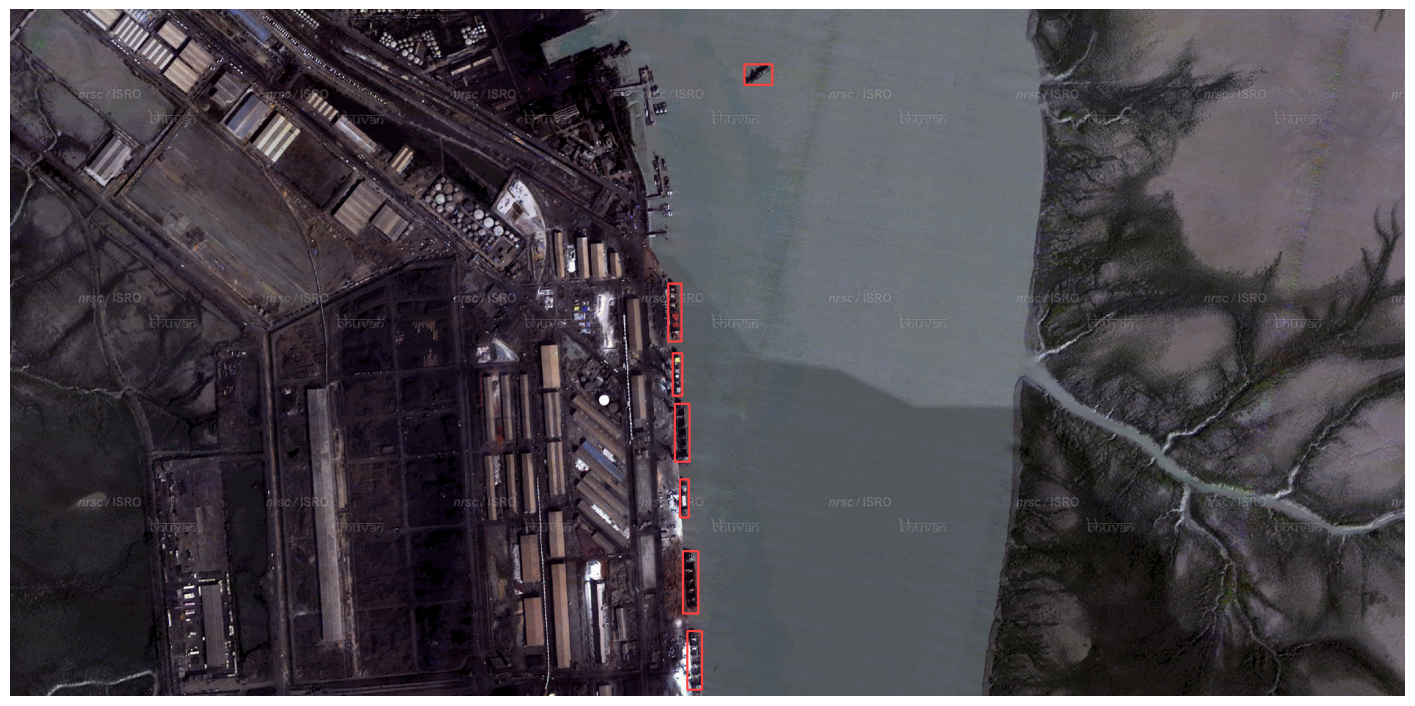

(<PIL.Image.Image image mode=RGB size=1904x937>,
 [ultralytics.engine.results.Results object with attributes:
  
  boxes: ultralytics.engine.results.Boxes object
  keypoints: None
  masks: None
  names: {0: 'airplane', 1: 'ship'}
  obb: None
  orig_img: array([[[ 55,  41,  53],
          [ 55,  41,  53],
          [ 55,  41,  53],
          ...,
          [117, 106, 116],
          [105,  99, 107],
          [107, 104, 115]],
  
         [[ 55,  41,  53],
          [ 55,  41,  53],
          [ 55,  41,  53],
          ...,
          [117, 106, 116],
          [107, 104, 115],
          [107, 104, 115]],
  
         [[ 57,  51,  57],
          [ 55,  41,  53],
          [ 55,  41,  53],
          ...,
          [107, 104, 115],
          [107, 104, 115],
          [107, 104, 115]],
  
         ...,
  
         [[ 25,  22,  25],
          [ 25,  22,  25],
          [ 39,  36,  37],
          ...,
          [ 42,  44,  49],
          [ 39,  38,  41],
          [ 39,  38,  41]],
  
       

In [9]:
url = "https://bhuvan.nrsc.gov.in/ngmaps?mode=Satellite#15.52/23.008159/70.225524"
model_highres_50 = YOLO("All Results/model_highres_50/weights/best.pt")

prediction_pipeline(model=model_highres_50)